# Evaluating CLM Simulations at NEON Tower Sites -- Tutorial 

This tutorial is an introduction to evaluating CLM at NEON tower sites.  It provides example visualizations and evaluation of simulated latent heat flux using NEON tower observations.  

**⚠️ Note: Before starting this tutorial, please make sure you successfully completed a simulation using the NEON_Simulation_Tutorial. Please use the same NEON site here.**
***
**The tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see the [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 

***

__In this tutorial :__

The tutorial has several components. Below you will find steps to: 
1. Explore CLM model data
1. Explore NEON observation data
1. Compare CLM and NEON latent heat flux data

________
<h2> 1. Explore CLM model data </h2>

There are countless ways of analyzing and processing model data. This tutorial uses Matplotlib, a comprehensive data visualization and plotting library for Python. For more information on Matplotlib, please see the [User's Guide](https://matplotlib.org/stable/users/index.html).

Before diving in, set the NEON site that you simulated in the cell below. **This needs to be the same site as you used in the previous tutorial.** Otherwise the data will not be available. NEON tower sites include:

>ABBY, BART, BLAN, CPER, DCFS, DSNY, GRSM, HARV, JERC, JORN, KONZ, MOAB, NOGP, OAES, ORNL, OSBS, SCBI, SERC, SOAP, SRER, STEI, TALL, TREE, UKFS, UNDE, WOOD.  

*The tutorial is currently set to use the ABBY site. If you ran a simulation for a different tower, please change the 4-character site name in quotes below to the same as your simulation.*

In [1]:
#Change the 4-character NEON site below to point to your NEON site:
neon_site = "ABBY"

***
<h3> 1.1 Locate model data </h3>

When the simulation completes, the data are transferred to an `archive` directory. In this directory, there are files that include data for every day of the simulation, as well as files that average model variables monthly. <p>

*Run the cell below to see a subset of the files listed:*

In [2]:
!ls ~/archive/{neon_site}.transient/lnd/hist/*2018*.nc |head -20

/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-01.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-02.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-03.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-04.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-05.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-06.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-07.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-08.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-09.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-10.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-11.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h0.2018-12.nc
/home/user/archive/ABBY.transient/lnd/hist/ABBY.transient.clm2.h1.2018-01-01

Each line of the list above includes the file path (`/home/user/archive/{simulation_name}/lnd/hist/`) and file name. The file names are automatically generated and comprise:
* the simulation name, which includes:
    * the NEON site
    * the type of simulation (here the simulation is "transient", meaning the model ran for the full length of available data)
* the date of simulated data


The NEON tower simulations generate two types of files:
* `*h0*`: Variables that are averaged monthly. One file is available for every month of the simulation.
* `*h1*`: Variables that are recorded every 30 minutes. Values are aggregated into one file for each day of the simulation. Each file includes 48 data points.
****


The files are saved in netcdf format (denoted with the `.nc` file extension), a file format commonly used for storing large, multi-dimensional scientific variables.
Netcdf files are platform independent and self-describing; each file includes metadata that describes the data, including: **variables**, **dimensions**, and **attributes**.

The figure below provides an example of the data structure in a netcdf file. For example, the dataset illustrated has two variables (temperature and pressure) that have three dimensions. Coordinate data (e.g., latitude, longitude, time) that describe the data are also included. 

![Netcdf](https://gdfa.ugr.es/python/climate_data/img/xarray2.png)
****

<h3>1.2 Explore Simulated Data </h3>

This step has several components, which are broken into smaller steps


<h4>1.2.1 Load Python Libraries</h4>

*Run the below code to import the required python libraries*

In [3]:
#Import Libraries
%matplotlib inline

import os
import sys
import time

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

from neon_utils import download_eval_files

<h4>1.2.2 Select Simulation Year</h4>

For simplicity, we focus on analyzing and evaluating a single year of data. <p>

The code below uses data for **2018**, but data are available through this year. You can select a different year by changing the year in the quotes below. <p> 
*Run the below code to identify the year of interest for making the plots. Note that the same year will be used to download observational data below*

In [4]:
#Specify the year below
year = "2018"

<h4>1.2.3 Load model data files</h4>

For reading the netCDF files, we are using the `xarray` Python package. You can learn more about [xarray on this website](http://xarray.pydata.org/en/stable/).

The variable `sim_path` points to the location where simulation data are stored.

*Run the code below to load the model data files. Note that the code will print how many files were loaded*

In [5]:
sim_path = "/home/user/archive/"+neon_site+".transient/lnd/hist/"
sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All Simulation files: [", len(sim_files), "files]")
#print(*sim_files,sep='\n')

All Simulation files: [ 365 files]


<h4> 1.2.4 Open model data files </h4>

Here we use the python function `xarray.open_mfdataset`, which opens multiple netcdf files as a single xarray dataset. For more information on this xarray function, check [the website for this function](
http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html).

*Run the below cell to read in the data files. Note that this step might take a few minutes.*

In [6]:
start = time.time()

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True)

end = time.time()
print("Reading all simulation files took:", end-start, "s.")


Reading all simulation files took: 102.4948878288269 s.


<h4> 1.2.5 Optional Step: Explore dataset from simulations </h4>

This step looks at the dataset that was just created from the simulation data. This step is not required, but will allow you to explore the python dataset and become familiar with the data.

*Run the below cell to find more information about the data*

In [7]:
ds_ctsm

,Array,Chunk
Bytes,140.16 kB,768 B
Shape,"(17520,)","(96,)"
Count,5099 Tasks,364 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,140.16 kB,768 B
Shape,"(17520,)","(96,)"
Count,5099 Tasks,364 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In the output, you can click on `Dimensions`, `Coordinates`, `Data Variables`, and `Attributes` to expand and see the details and metadata associated with this dataset. 

If you click on `Data Variables`, you will see a list of all the available variables. You can click on each variable to see a description of the variable (the `long_name`) and its `units`, as well as other information. Here are a few questions to consider:

**Questions to consider** 
1. What are the avaibale variables in the dataset?
2. What is the `long_name` and `unit` of the variable `FSH`? 
3. Can you find the dimensions of this variable? 

**💡 Tip**: 
Xarray has built-in plotting functions. For quick inspection of a variable, we can use `.plot()` to see it. Below, let's make a quick plot of the Gross Primary Production (`GPP`) variable:

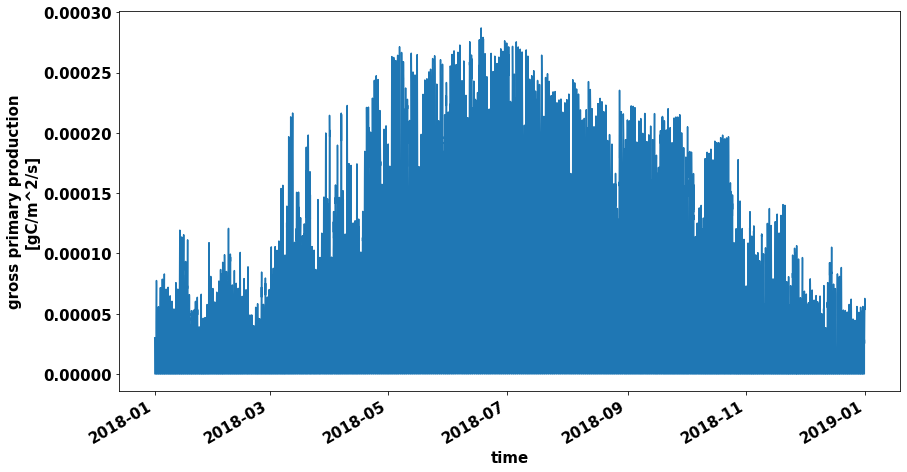

In [23]:
ds_ctsm['GPP'].plot(aspect=2, size=7);

________
<h2> 2. Explore NEON Tower Observation Data </h2>

<h3> 2.1 Download NEON data </h3>

This step uses a preestablished function (`download_eval_files`) that downloads the NEON observational data files for the site and year specified above. 


In [15]:
eval_dir = "/home/user/evaluation_files/"

download_eval_files(neon_site, eval_dir)

Download finished successfully for listing.csv .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-01.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-02.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-03.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-04.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-05.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-06.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-07.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-08.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-09.nc .
Download finished successfully for /home/user/evaluation_files/ABBY/ABBY_eval_2018-10.nc .
Download finished successfully for /home/

<h3> 2.2 Load NEON data </h3>
   
Next, run the two cells of code below. The code will print a list of files and read them into a dataset, similar to the steps above.

In [16]:
eval_path = os.path.join('/home/user/evaluation_files/',neon_site)

eval_files = sorted(glob(join(eval_path,neon_site+"_eval_"+year+"*.nc")))

print("All Observation files:")
print(*eval_files,sep='\n')

All Observation files:
/home/user/evaluation_files/ABBY/ABBY_eval_2018-01.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-02.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-03.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-04.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-05.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-06.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-07.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-08.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-09.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-10.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-11.nc
/home/user/evaluation_files/ABBY/ABBY_eval_2018-12.nc


In [17]:
start = time.time()

ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

end = time.time()
print("Reading all observation files took:", end-start, "s.")

Reading all observation files took: 0.5512197017669678 s.


<h3> 2.3 Optional Step: Explore NEON data </h3>

Similar to above, you can explore NEON data by clicking to see details about the variables, coordinate, and attributes.

In [18]:
ds_eval

<xarray.Dataset>
Dimensions:          (lat: 1, lon: 1, time: 17520)
Coordinates:
  * lat              (lat) float64 45.76
  * lon              (lon) float64 237.7
  * time             (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:30:00
Data variables:
    LATIXY           (time, lat) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    LONGXY           (time, lon) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    NEE              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT      (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Rnet             (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    ZBOT             (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    NEE_fqc          (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH_fqc          (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT_fqc  (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP_fqc          (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Rnet_fqc         (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
Attributes:
    created_on:    Sat Aug  7 02:51:54 2021
    created_by:    David Durden
    created_from:  /home/ddurden/eddy/tmp/CLM/ABBY/ABBY_2018-01-01_2021-07-01...
    NEON site:     ABBY
    created_with:  flow.api.clm.R
    supported_by:  This data development was funded by the National Science F...

*Let's quickly inspect the Net Radiation (`Rnet`) variable by making a simple plot:*

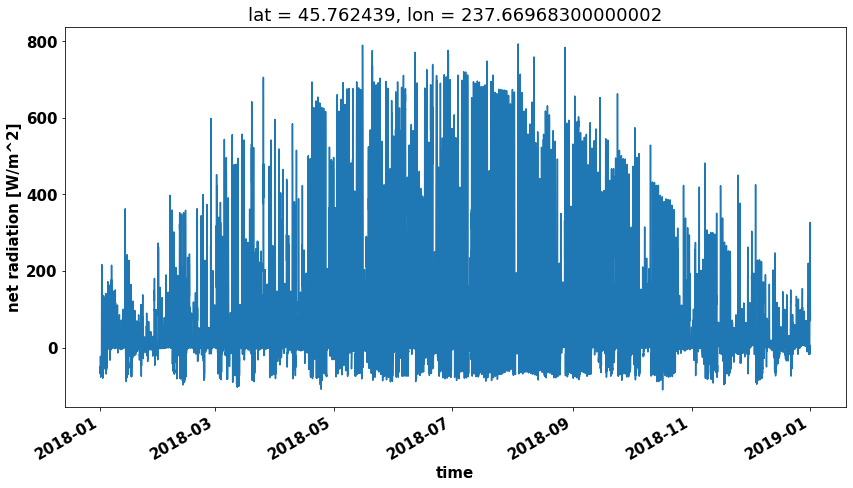

In [22]:
ds_eval['Rnet'].plot(aspect=2, size=7);

__________
# 3. Compare CLM and NEON latent heat flux data

So far, we uploaded files of observational and model data. In this section we will compare observed and simulated **latent heat fluxes**. You can also explore other available variables with this code.
***

#### Format Data
The next cell of code processes the data into a common format to make analysis easier. 

*Run the below cell of code to extract the variables needed for this notebook and create a single dataframe that includes all the extracted variables*

In [24]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['FCEV', 'FCTR', 'FGEV']

df_ctsm = pd.DataFrame({'time':ds_ctsm.time})

for var in ctsm_vars:
    field = np.ravel ( ds_ctsm[var])     
    df_ctsm[var]=field


#Convert NEON data to a Pandas Dataframe for easier handling:
eval_vars = ['EFLX_LH_TOT']

df_eval = pd.DataFrame({'time':ds_eval.time})

for var in eval_vars:
    field = np.ravel ( ds_eval[var])     
    df_eval[var]=field

#-- make df_all that includes both obs and sim
df_all = df_eval

#-- add simulation data to df_all and adjust for offset time dimension:
for var in ctsm_vars:
    sim_var_name = "sim_"+var
    #-- shift simulation data by one
    df_all[sim_var_name]=df_ctsm[var].shift(-1).values
    


*The next cell gives us a quick look at the dataframe to make sure the data are available*

In [25]:
df_all.head()

,time,EFLX_LH_TOT,sim_FCEV,sim_FCTR,sim_FGEV
0,2018-01-01 00:00:00,7.999955,-7.638256,1.545730e-16,6.177156
1,2018-01-01 00:30:00,9.523534,-9.999990,0.000000e+00,8.121943
2,2018-01-01 01:00:00,9.358360,-8.272110,0.000000e+00,7.193620
3,2018-01-01 01:30:00,5.013022,-7.173703,0.000000e+00,6.415617
4,2018-01-01 02:00:00,2.368721,-7.002048,0.000000e+00,6.262212


### 3.1 What is latent heat flux?

Below we explore how well CLM simulates latent heat flux, which is directly observed at NEON towers. Latent heat flux is the energy for water evaporation from the ecosystem. Latent heat flux is a combination of plant transpiration, evaporation from leaf surfaces (e.g., from dew, after precipitation events), and evaporation from the soil:

$$ Latent Heat Flux = Transpiration + Canopy Evaporation + Ground Evaporation $$

Although NEON towers cannot distinguish how much each of these processes contributes to latent heat flux, CLM simulations can help us to disentangle the role of each. 

First we will calculate latent heat flux simulated by CLM by summing the component fluxes in the above equation. The CLM variables are:

>$FCEV$: Canopy evaporation (W m<sup>-2</sup>) <br>
>$FCTR$: Canopy transpiration (W m<sup>-2</sup>) <br>
>$FGEV$: Ground evaporation (W m<sup>-2</sup>) <br>

*Run the below cell to calculate simulated latent heat flux*

In [26]:
clm_var = 'sim_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_all['sim_FCEV'] \
                 + df_all['sim_FCTR']\
                 + df_all['sim_FGEV']

print (df_all)

                     time  EFLX_LH_TOT   sim_FCEV      sim_FCTR  sim_FGEV  \
0     2018-01-01 00:00:00     7.999955  -7.638256  1.545730e-16  6.177156   
1     2018-01-01 00:30:00     9.523534  -9.999990  0.000000e+00  8.121943   
2     2018-01-01 01:00:00     9.358360  -8.272110  0.000000e+00  7.193620   
3     2018-01-01 01:30:00     5.013022  -7.173703  0.000000e+00  6.415617   
4     2018-01-01 02:00:00     2.368721  -7.002048  0.000000e+00  6.262212   
...                   ...          ...        ...           ...       ...   
17515 2018-12-31 21:30:00   127.891286  37.526901  8.447243e+00  0.421997   
17516 2018-12-31 22:00:00     6.909593  36.608852  7.772662e+00  0.761458   
17517 2018-12-31 22:30:00    -0.758793  31.220009  7.147894e+00  0.631587   
17518 2018-12-31 23:00:00    -2.582525  25.218470  5.901747e+00  0.661987   
17519 2018-12-31 23:30:00    -6.315270        NaN           NaN       NaN   

       sim_EFLX_LH_TOT  
0            -1.461100  
1            -1.878047  


****
### 3.2 Plotting latent heat flux

#### 3.2.1 Daily Timeseries
This creates a time-series plot comparing daily average latent heat flux from observations (NEON) and simulations (CLM). To start, we need calculate the daily averages. Run the below cells of code in order to create the plot.

*First, we need to extract year, month, day and hour from time column*

In [27]:
#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

*Next, calculate daily averages*

In [28]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])

In [29]:
plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var

plot_var_desc = "Latent Heat Flux"
plot_var_unit= "Wm-2"

Using the daily averages, we will create a plot using Python's [matplotlib package:](https://matplotlib.org/)

*Run the below cell to create the plot:*

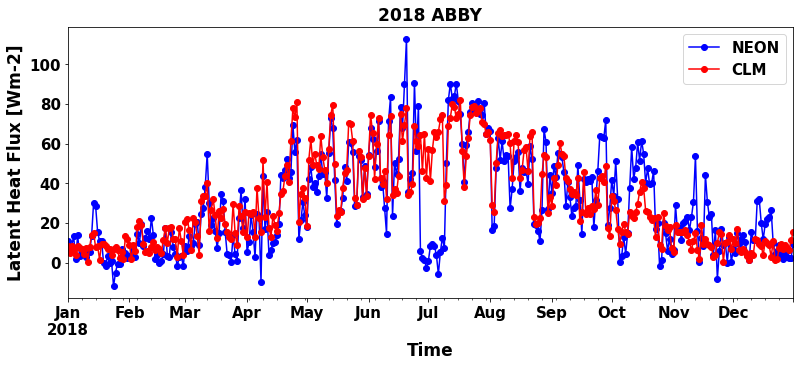

In [30]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = 'b',label="NEON")
df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 'o' ,ax =ax , color = 'r',label="CLM")

plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

Are the simulations and observations similar? 

It is important to also look at variability, as this gives us an indication of when and where simulations are outside the range of observed values. 

*Let's explore variability by adding the daily standard deviation as a shaded area to the plot*

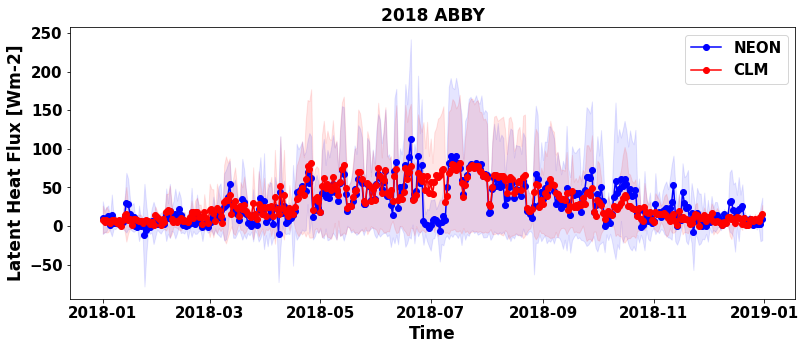

In [31]:
df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = 'b',label="NEON")
plt.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(df_daily.time, df_daily.EFLX_LH_TOT-df_daily_std.EFLX_LH_TOT, df_daily.EFLX_LH_TOT+df_daily_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
plt.fill_between(df_daily.time, df_daily.sim_EFLX_LH_TOT-df_daily_std.sim_EFLX_LH_TOT, df_daily.sim_EFLX_LH_TOT+df_daily_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')

plt.legend()
plt.xlabel('Time', fontsize=17)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

The standard deviation allows us to see when CLM under-predicts or over-predicts the NEON tower observations.

#### **Questions to consider:**

1. When is the latent heat hlux highest at this site? When is it lowest? <br>
1. Does CLM match NEON tower observations? <br>
1. What times of year does CLM shows the best and worst performance in predicting latent heat flux ? <br>

*****
#### 3.2.2 Monthly Averages & Component Fluxes: Absolute Values

Next we will disentangle whether transpiration, canopy evaporation, or ground evaporation is the dominant contribution to latent heat flux during each month using CLM data. As mentioned in section 3.1, NEON observations cannot distinguish how much each of these processes contributes to latent heat fluxes. 

*Run the cell below to calculate monthly averages*

In [32]:
df_monthly = df_all.groupby(['year','month']).mean().reset_index()
df_monthly["day"]=15
df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

##### Next, create a stacked bar chart showing components of simulated latent heat flux over different months

*Run the cell below to create the plot*

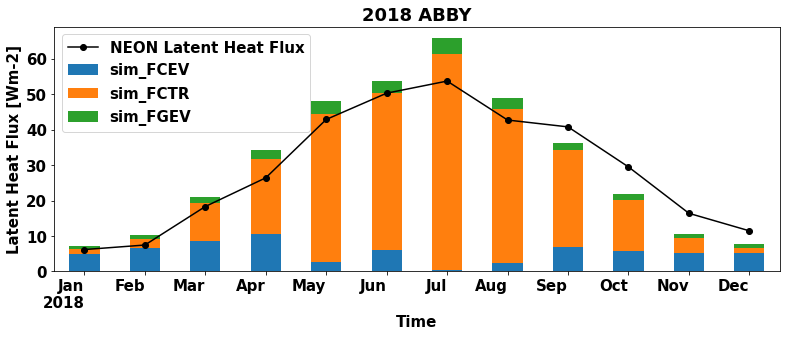

In [44]:
def line_format(label):
    """
    Helper function to convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month


plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax , color = 'black',label="NEON Latent Heat Flux",use_index=False)
df_monthly[['time','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))

plt.xlabel('Time')
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]")
        
plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

The monthly averages of NEON latent heat flux observation are plotted as a line on top of the barplot of CLM data for reference.

#### **Questions to consider:**

1. Which months does CLM overestimate and underestimate observed latent heat fluxes for this site? 
1. What times of year is canopy transpiration (`FCTR`) the largest contributor to the total CLM latent heat flux?
1. What times of year are canopy evaporation (`FCEV`) and ground evaporation (`FGEV`) important contributors to the total CLM latent heat flux? 
1. What is the dominant component flux when CLM overestimates observed latent heat fluxes? When CLM underestimates latent heat fluxes?
****

#### 3.2.3 Monthly Averages & Component Fluxes: Proportional Contributions
It might be easier to see the proportional contributions of transpiration and evaporation fluxes to total latent heat flux. We can look at a more advanced plot with two y-axes that helps to illustrate the absolute values of monthly latent heat fluxes and the proportion of component fluxes each month. 

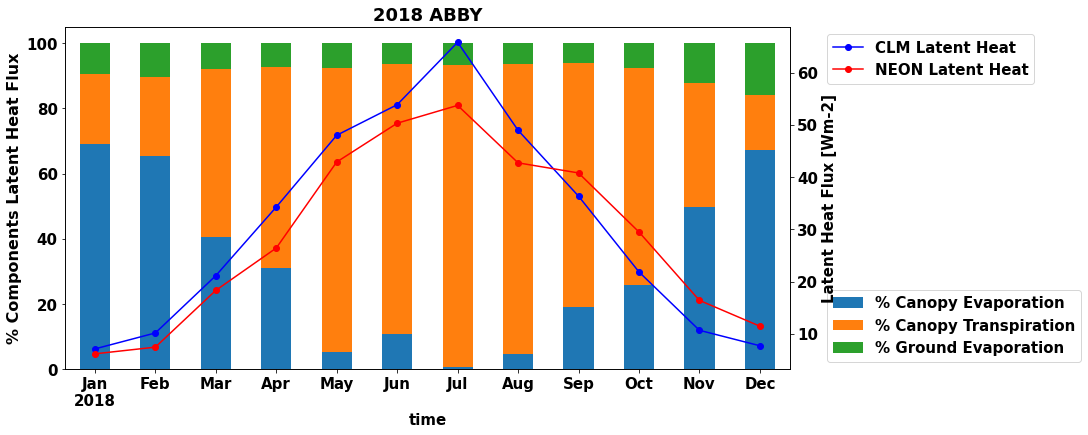

In [34]:
#-- calculate the percentage of total latent heat flux
df_monthly ['sim_FCEV_perc']= df_monthly ['sim_FCEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FCTR_perc']= df_monthly ['sim_FCTR']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100
df_monthly ['sim_FGEV_perc']= df_monthly ['sim_FGEV']/(df_monthly ['sim_FCEV']+df_monthly ['sim_FCTR']+df_monthly ['sim_FGEV'])*100

plt.figure(num=None, figsize=(13, 7),  facecolor='w', edgecolor='k')
        
ax = plt.gca()

df_monthly[['time','sim_FCEV_perc','sim_FCTR_perc','sim_FGEV_perc']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0)

ax.set_xticklabels(map(line_format, df_monthly.time))
ax.set_ylabel('% Components Latent Heat Flux', fontsize=16)
ax.legend(bbox_to_anchor=(1.04,0), loc="lower left",labels=["% Canopy Evaporation","% Canopy Transpiration","% Ground Evaporation"])
ax2 = ax.twinx()
df_monthly.plot ( x= 'time', y = 'sim_EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'b',label="CLM Latent Heat",use_index=False)
df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax2 , color = 'r',label="NEON Latent Heat",use_index=False)

plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.title(year+" "+neon_site, fontweight='bold')
plt.show()

______________

#### 3.2.4 Annual and Seasonal Correlations
Scatter plots can help to describe the relationship between latent heat flux and the component transpiration and evaporation fluxes. We can look at these relationships using data from CLM simulations.

First, we plot relationships for annual average data.

*Run the cells below to first define a generic function that plot scatter diagrams and add a regression line, and then to generate the plots.*

In [35]:
#Defining generic function for scatter plots
def detailed_scatter (x, y, color):
    plt.scatter (x,y, marker="o",color = color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,line,'black', label='y={:.2f}x+{:.2f}'.format(slope,intercept)+" (R2="+"{:.2f}".format(r_value)+")")
    plt.legend(fontsize=13)

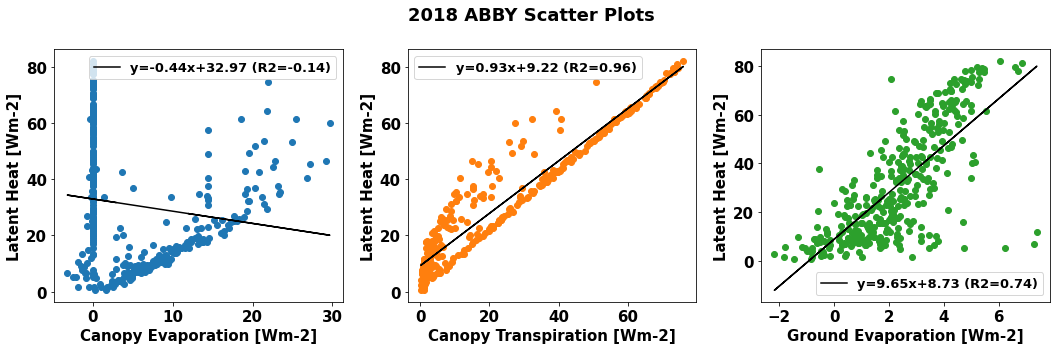

In [36]:
#Generating plots
plt.figure(num=None, figsize=(15, 5),  facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
detailed_scatter (df_daily.sim_FCEV, df_daily.sim_EFLX_LH_TOT, '#1f77b4')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(1, 3, 2)
detailed_scatter (df_daily.sim_FCTR, df_daily.sim_EFLX_LH_TOT, '#ff7f0e')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(1, 3, 3)
detailed_scatter (df_daily.sim_FGEV, df_daily.sim_EFLX_LH_TOT,'#2ca02c')

plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

plt.suptitle(year+" "+neon_site+" Scatter Plots", fontweight='bold')

plt.tight_layout()
plt.show()

****
Since the relationships between latent heat flux and the component transpiration and evaporation fluxes likely vary throughout the year, we can investigate how the relationships change during different seasons.

*Run the cell below to generate scatter plots by season*

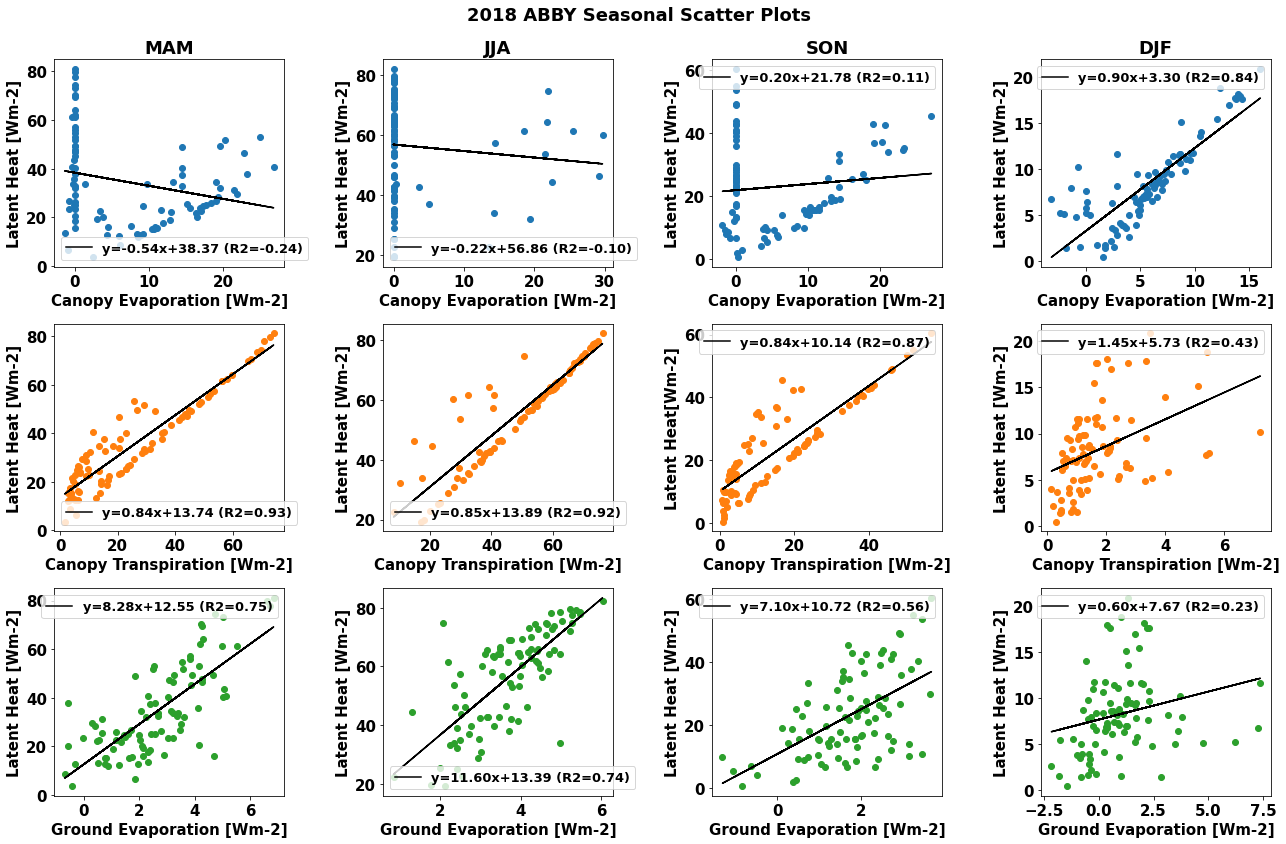

In [37]:
df_daily['season'] = ((df_daily['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

fig= plt.figure(num=None, figsize=(18,12),  facecolor='w', edgecolor='k')

season = 'MAM'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 1)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 5)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')


plt.subplot(3, 4, 9)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'JJA'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 2)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 6)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 10)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')


season = 'SON'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 3)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 7)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat[Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 11)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT,'#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

season = 'DJF'
df_season =  df_daily[df_daily['season']==season]

plt.subplot(3, 4, 4)
detailed_scatter (df_season.sim_FCEV, df_season.sim_EFLX_LH_TOT, '#1f77b4')
plt.title(season, fontweight='bold')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Evaporation [Wm-2]')

plt.subplot(3, 4, 8)
detailed_scatter (df_season.sim_FCTR, df_season.sim_EFLX_LH_TOT, '#ff7f0e')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Canopy Transpiration [Wm-2]')

plt.subplot(3, 4, 12)
detailed_scatter (df_season.sim_FGEV, df_season.sim_EFLX_LH_TOT, '#2ca02c')
plt.ylabel('Latent Heat [Wm-2]')
plt.xlabel('Ground Evaporation [Wm-2]')

fig.suptitle(year+" "+neon_site+ " Seasonal Scatter Plots", fontweight='bold')
fig.tight_layout()

plt.show()

--------
#### 3.2.5 Average Diel Cycle

Latent heat flux also changes throughout the day. Does CLM capture the diel cycle that NEON observes? We can compare the average diel cycle from NEON observations and CLM simulations to find out.

*Run the cells below to calculate the annual average diel cycle and to generate a plot*

In [38]:
# Calculate annual average diel cycle and bias
diel_df_mean = df_all.groupby('hour').mean().reset_index()
diel_df_std = df_all.groupby('hour').std().reset_index()

diel_df_mean['EFLX_LH_TOT_bias'] = diel_df_mean['sim_EFLX_LH_TOT']- diel_df_mean['EFLX_LH_TOT']

diel_df_mean.head()

,hour,EFLX_LH_TOT,sim_FCEV,sim_FCTR,sim_FGEV,sim_EFLX_LH_TOT,year,month,day,EFLX_LH_TOT_bias
0,0,40.505909,4.253603,44.115070,3.317377,51.686050,2018.0,6.526027,15.720548,11.180142
1,1,24.175939,2.027648,25.940630,2.722302,30.690580,2018.0,6.526027,15.720548,6.514641
2,2,8.932081,0.553420,7.682308,1.986824,10.222552,2018.0,6.526027,15.720548,1.290471
3,3,2.574138,-0.256223,0.354500,2.181391,2.279668,2018.0,6.526027,15.720548,-0.294470
4,4,2.737836,-0.172287,0.007739,2.376632,2.212084,2018.0,6.526027,15.720548,-0.525753


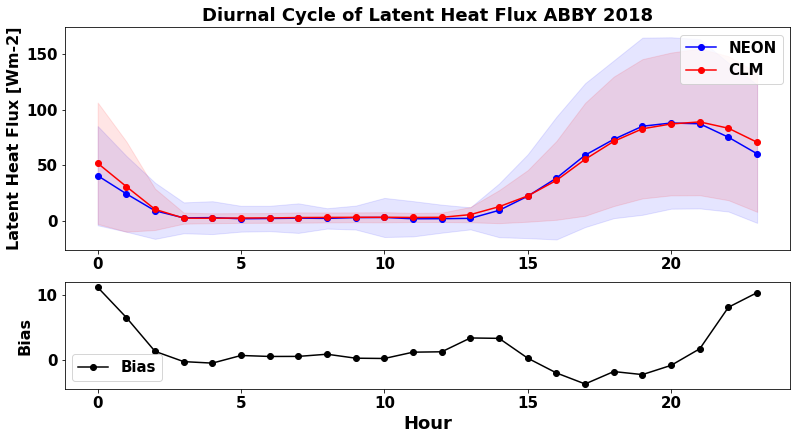

In [39]:
# Plot annual average diel cycle and bias
plt.figure(num=None, figsize=(13, 9),  facecolor='w', edgecolor='k')
        
plt.subplot(2, 1, 1)  
        
plt.plot ( diel_df_mean.hour, diel_df_mean['EFLX_LH_TOT'], marker = 'o' , color = 'b',label="NEON")
plt.plot ( diel_df_mean.hour, diel_df_mean['sim_EFLX_LH_TOT'], marker = 'o' , color = 'r',label="CLM")

plt.fill_between(diel_df_mean.hour, diel_df_mean.EFLX_LH_TOT-diel_df_std.EFLX_LH_TOT, diel_df_mean.EFLX_LH_TOT+diel_df_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
plt.fill_between(diel_df_mean.hour, diel_df_mean.sim_EFLX_LH_TOT-diel_df_std.sim_EFLX_LH_TOT, diel_df_mean.sim_EFLX_LH_TOT+diel_df_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)

plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')
plt.legend()
plt.subplot(4, 1, 3)  

ax = plt.gca()    
diel_df_mean.plot ( x= 'hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax , color = 'black',label='Bias')
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Bias', fontsize=16)
plt.show()

*Note that the above code plots a diel cycle that is not centered. We are working with NEON to add the time zone to the evaluation data so that we can more easily center these plots on local noon.*

***
How do transpiration and evaporation components of latent heat flux change throughout the day? 

*Run the cells below to find out*

In [40]:
#Calculating diel cycle flux proportions
diel_df_mean['sim_FCEV_perc']= diel_df_mean ['sim_FCEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FCTR_perc']= diel_df_mean ['sim_FCTR']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100
diel_df_mean ['sim_FGEV_perc']= diel_df_mean ['sim_FGEV']/(diel_df_mean ['sim_FCEV']+diel_df_mean ['sim_FCTR']+diel_df_mean ['sim_FGEV'])*100

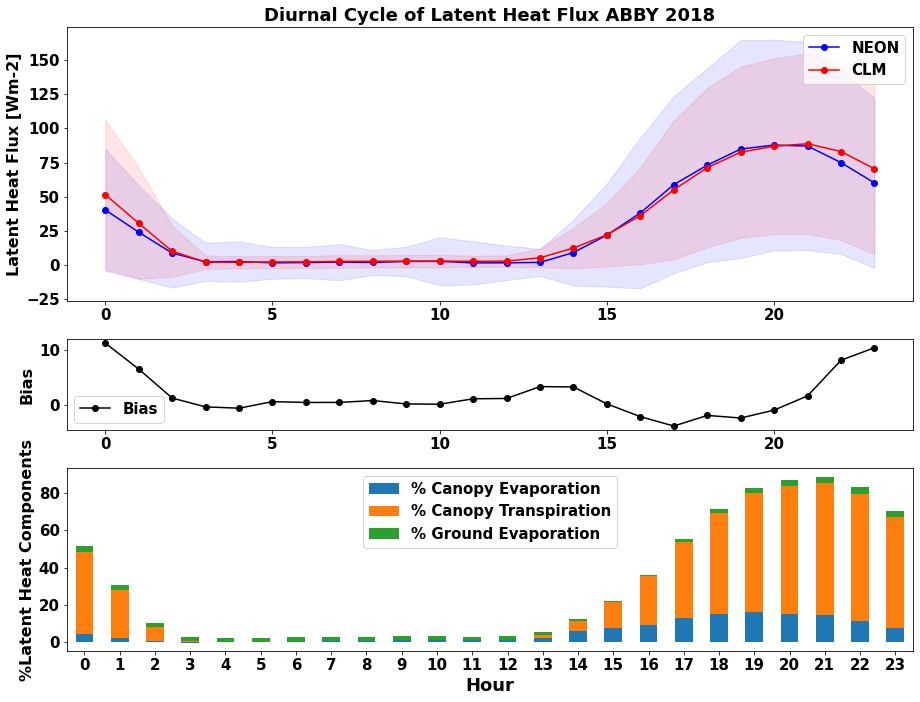

In [46]:
#plotting diel cycl flux proportions
from matplotlib import gridspec

fig= plt.figure(num=None, figsize=(13, 10),  facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 2]) 

ax0 = plt.subplot(gs[0])
        
ax0.plot ( diel_df_mean.hour, diel_df_mean['EFLX_LH_TOT'], marker = 'o' , color = 'b',label="NEON")
ax0.plot ( diel_df_mean.hour, diel_df_mean['sim_EFLX_LH_TOT'], marker = 'o' , color = 'r',label="CLM")

ax0.fill_between(diel_df_mean.hour, diel_df_mean.EFLX_LH_TOT-diel_df_std.EFLX_LH_TOT, diel_df_mean.EFLX_LH_TOT+diel_df_std.EFLX_LH_TOT ,alpha=0.1, color = 'b')
ax0.fill_between(diel_df_mean.hour, diel_df_mean.sim_EFLX_LH_TOT-diel_df_std.sim_EFLX_LH_TOT, diel_df_mean.sim_EFLX_LH_TOT+diel_df_std.sim_EFLX_LH_TOT ,alpha=0.1, color = 'r')
plt.ylabel('Latent Heat Flux [Wm-2]', fontsize=16)
plt.legend()
plt.title("Diurnal Cycle of Latent Heat Flux "+neon_site+" "+year, fontweight='bold')

ax1 = plt.subplot(gs[1])
diel_df_mean.plot ( x= 'hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax1 , color = 'black',label='Bias')
plt.xlabel('', fontsize=18)
plt.ylabel('Bias', fontsize=16)

ax2 = plt.subplot(gs[2])
diel_df_mean[['hour','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'hour',stacked='True',ax=ax2,rot=0)
plt.ylabel('%Latent Heat Components', fontsize=16)
plt.xlabel('Hour', fontsize=18)
plt.legend(labels=["% Canopy Evaporation","% Canopy Transpiration","% Ground Evaporation"])

plt.tight_layout()

fig.show()

## Congratulations! You have:
1. Accessed the CTSM model data
1. Accessed the NEON observational data
1. Evaluated CTSM latent heat fluxes compared to NEON tower observations
1. Determined when transpiration and evaporation fluxes drive latent heat fluxes
1. Learned how to average over different time periods and create different types of plots

#### If you would like to learn more advanced interactive visualization tools, please see the [tutorial coming soon].
You can also use this script to explore additional CLM and NEON data by changing the variables in section 3 of this script.
